In [1]:
# -*- coding: utf-8 -*-

## Project description 

We are working on the detection of Rent announcements Rent amount predection in Paris.
This Project maybe extended to support other cities. It's a Proof Of Concept.

## Project Implementation

### Import Section for used libraries

In [1]:
from time import sleep #Sleeep Fucntion to avoid getting banned
from bs4 import BeautifulSoup  #Importing Library For Web scrapping (XML and HTML)
import requests #Importing Library For HTTP Request Method
from lxml import html # XML abd HTML parser
import lxml.etree as et #XML Library to parse SVG File and Edit it before plot
import pandas as pd # Maths Library
from unidecode import unidecode # Library to unicode string
import re # Library for regular Expressions
from IPython.display import display, HTML # Library for pretty printing pandas data_frames
from sklearn.utils import shuffle # Library used to shuffle rows in data frames.
from IPython.display import IFrame # Library to import a google's map IFRAME into notrebook
from IPython.display import SVG, display # Library to render svg Paris map
import numpy as np #Maths Library 
import matplotlib.pyplot as plt # Viz Library
import matplotlib as mpl # Viz Library
from sklearn import datasets, linear_model #training Library for ML
from sklearn.metrics import mean_squared_error, r2_score #Score and error calculation Library
import seaborn as sns #Library imported from plots
from sklearn import preprocessing #Preprocess data scaler, normlize
from sklearn.decomposition import PCA #Principle Component Analysis for dimension's reduction
from sklearn.model_selection import train_test_split #Splitting DF into Train and Test Sets
from wordcloud import WordCloud #Package to show most used world
 # Package for natural langage processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
 # Package for statistics
from scipy.cluster import hierarchy
from scipy import ndimage
from scipy.misc import imread
from scipy import stats
from PIL import Image
import random


### Defining Webscraping functions 

This function will return a list of json. 
Each json contains article's titles and links

In [3]:
def getJSONLinksFromContentReponse(Response):
    
        docHtmlContent = Response.content #Getting the body content of the httpResponse
        html_soup = BeautifulSoup(docHtmlContent, 'html.parser') # Parsing the Response Body
        section = html_soup.find("section", {"class": "tabsContent block-white dontSwitch"}) #Searching for section containing list of announcement
        try : 
            ul = section.find("ul") # Getting List of the announcements
            li = ul.findAll("li") # Getting announcements Elements from the previous List
        except:
            return []
        announcementsList = [] # List of announcements
        for item in li:
            '''
            Parsing each announcement and 
            Making a JSON which contains the details.
            Cleaning Data for the URL of the announcement,
            And the Category of the annoucement
            and preparing it for a Future use
            '''
            announcementsList.append({ 'PostTitle' : item.find('a')['title'],'link' : "https:"+(item.find('a')['href'])}) 
        return announcementsList

This Function will get Information from each Announcements.
It will return a list contaning details about each announcement. 
In this function we will try to scrap every thing (Unused fields in this project) .. Maybe it will be usefull in the futur.

In [4]:
def proceedAnalysis(theAnnouncementsJSONList,isProfessionalAnnouncement):    
   
    titleList= []
    postLinkList= []
    rentAmountList= []
    buildingPostCodeList= []
    posthasPhoneContactList= []
    posthasMailContactList= []
    postNumberOfPhototList= []
    postDescriptionList= []
    isBuildingfurnishedList= []
    buildingAreaList= []
    buildingRommsNumberList= []
    isProfessionalAnnouncementList = [] 
    
    if(isProfessionalAnnouncement) :
        print("Parsing scraped HTML Responses for professional announcements")          
    else :
        print("Parsing scraped HTML Responses for inidvidual announcements")   
        
    collected = 0
    collectedSuccess = 0
    problemPrice= 0
    for articleJSON in theAnnouncementsJSONList:
        title = articleJSON["PostTitle"]
        postLink = articleJSON["link"]
        pageAnnouncementResponse = requests.get(postLink) # Opening the url of the announcement
        if(pageAnnouncementResponse.ok) : #Announcement Response is well            
            docHtmlContent = pageAnnouncementResponse.content #Getting the body content of the httpResponse
            #Solving Problems with encoding
            try :
                DOM = html.fromstring(docHtmlContent.decode('utf8'))  # DOM is the html document oriented object representation
            except UnicodeDecodeError :
                DOM = html.fromstring(docHtmlContent.decode('latin-1'))  # DOM is the html document oriented object representation

            MaybeInsertedIntoDataFrame = True #boolean which will control saving of the data (Yes/No if there's needed fields)
            #Getting tagged (id,class or itemprop) fields
            #Getting the Rent Amount
            try :
                rentAmount = int("".join(re.findall('\d+', (DOM.xpath('//h2[@itemprop="price"]/span/text()')[1]))))             
            except :
                MaybeInsertedIntoDataFrame = False
           
            #Getting Post Code of the building
            try :
                buildingPostCode = int(re.findall('\d+',DOM.xpath('//span[@itemprop="address"]/text()')[0])[0])
            except IndexError :
                buildingPostCode = "NaN"
            
            #Getting number of photos of the announcement (There is a problem when the post has no photo si we catch this case)
            try:
                postNumberOfPhoto = ((re.findall('\d+',DOM.xpath('//p[@class="item_photo"]/text()')[0]))[0])
            except: 
                #When the Post hasn't any photo
                if(len(DOM.xpath('//div[@class="item_image empty"]'))):
                    postNumberOfPhoto = 0
                else :
                    postNumberOfPhoto = 1
                 
            #Getting the number of the available contacts in the announcement 
            postNumberOfContact = len(DOM.xpath('//div[@class="box-grey-light mbs align-center"]/div')[0].getchildren())
            posthasPhoneContact = len(DOM.xpath('//button[@class="button-orange large phoneNumber trackable"]'))
            posthasMailContact = 0
            if(postNumberOfContact - posthasPhoneContact > 0):
                posthasMailContact = 1
            
            #Getting the description of the announcement 
            try :
                postDescription = ' '.join(DOM.xpath('//p[@itemprop="description"]/text()'))   
            except :
                postDescription  = "NaN"
            
            
        
            
            # Getting non Tagged fields by Text Content
            isBuildingfurnished = "NaN" #default value "non meublé"
            buildingArea = "NaN" #default Value in m² 
            buildingRommsNumber = "NaN" #default rooms number equals 1
            othersNonTaggedFields = DOM.xpath('//section[@class="properties lineNegative"]/div[@class="line"]/h2[@class="clearfix"]/span/text()')[:8]
            
            #Checking if other informations exist
            FoundOtherFields = True
            for elt in ["Meublé / Non meublé","Pièces","Surface"]:
                FoundOtherFields = FoundOtherFields and (elt in othersNonTaggedFields)
                
            for cpt in range(0,len(othersNonTaggedFields)):
                key = (othersNonTaggedFields[cpt].strip())
                if key in ["Meublé / Non meublé","Pièces","Surface"]: # Ces Champs nous concernent pour la suite
                    value = othersNonTaggedFields[cpt+1].strip()
                    if((key == "Meublé / Non meublé")):
                        isBuildingfurnished = 0
                        if (value == "Meublé"):
                            isBuildingfurnished = 1
                    if(key == "Pièces"):
                        buildingRommsNumber = int(value)
                    if(key == "Surface"):
                        buildingArea = re.findall('\d+',value)[0]      
            
            
            ### Cleaning Data ###
            #Treatment of aberrant values, we won't insert illogic values in our dataFrame
            squareMeterRent = (float(rentAmount)/float(buildingArea))
            
            #Inserting only completely  Rows with a present Price field
            if(MaybeInsertedIntoDataFrame):
                titleList.append(title)
                postLinkList.append(postLink)
                rentAmountList.append(rentAmount)
                buildingPostCodeList.append(buildingPostCode)
                postNumberOfPhototList.append(postNumberOfPhoto)
                posthasPhoneContactList.append(posthasPhoneContact)
                posthasMailContactList.append(posthasMailContact)
                postDescriptionList.append(postDescription)
                isBuildingfurnishedList.append(isBuildingfurnished)
                buildingAreaList.append(buildingArea)
                buildingRommsNumberList.append(buildingRommsNumber)
                isProfessionalAnnouncementList.append(isProfessionalAnnouncement) #Extracting from PRO agencies so there is no fraudes
    print("Contructing Data Frame")      
    df_Announcements = pd.DataFrame(list(zip(buildingPostCodeList,buildingRommsNumberList,postNumberOfPhototList,posthasMailContactList,posthasPhoneContactList,postDescriptionList,isBuildingfurnishedList,buildingAreaList,isProfessionalAnnouncementList,rentAmountList)),\
    columns = ['Zip Code','Rooms Number','NbPhotos','has_mail','has_phone','description','is furnished','Area','Rent from Agency','Rent(€)'])
    return df_Announcements


We observed Some different values for the same Zip Code.
for example 75116 for 75016. So this function aim to treat this issue.


In [5]:
def processZipCodes(df):
    for i in range(0,len(df["Zip Code"])):
        zipCode =df["Zip Code"][i]
        df.at[i, "Zip Code"] = "750"+(str(zipCode)[-2:])
    return df

This is tha scrapping function. It will grab data from the net.
Then it'll pass them to another function which will process them.
Then it'll save these scrapped data into an Excel which will be used
for vizualisation and machine Learning
    

In [6]:
def Scrapping(startPage,endPage):    
    # Init For our list and http Response status
    tabProffessionalResponses = []
    httpProffessionalResponseSuccess = True 
   
    tabIndividualResponses = []
    httppIndividualResponseSuccess = True 
    
    # We'll need it later for testing our classification model
    try:
        httpIndividualResponse = requests.get('https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?ret=1&ret=2&f=p') #Getting HTTPReponse from URL    
        httpIndividualResponseSuccess  = httpIndividualResponse.ok # Ok is a property of the Reponse which is a Boolean
    except:
        return None
    
    # Getting list of professional Announcements ( 1 page ~ 35 announcements )
    for pageNumber in range(startPage,endPage+1) : 
        try:
            #Scraping Proffesional Announcements
            httpProffessionalResponse = requests.get('https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?o='+str(pageNumber)+'&ret=1&ret=2&f=c') #Getting HTTPReponse from URL        
            httpProffessionalResponseSuccess  = (httpProffessionalResponseSuccess and httpProffessionalResponse.ok) # Ok is a property of the Reponse which is a Boolean
            tabProffessionalResponses.append(httpProffessionalResponse)

            #Scraping Individual Announcements
            httpIndividualResponse = requests.get('https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?o='+str(pageNumber)+'&ret=1&ret=2&f=p') #Getting HTTPReponse from URL        
            httpIndividualResponseSuccess  = (httpIndividualResponseSuccess and httpIndividualResponse.ok) # Ok is a property of the Reponse which is a Boolean
            tabIndividualResponses.append(httpIndividualResponse)
        except:
            return None
        
    if(  httpIndividualResponseSuccess and httpProffessionalResponseSuccess): # ALL IS OK
        print("Reponses are available and ready for parse")
        
        listOfProffessionalAnnouncements = []
        for professionalAnnoucementsResponse in tabProffessionalResponses :
            linkedResponse = getJSONLinksFromContentReponse(professionalAnnoucementsResponse)
            if(len(linkedResponse)>0):
                #Construction of List of details for Announcements and concatenate them
                listOfProffessionalAnnouncements = listOfProffessionalAnnouncements + linkedResponse 
       
        listOfIndividualAnnouncements = []
        for individualAnnoucementsResponse in tabIndividualResponses :
            linkedResponse = getJSONLinksFromContentReponse(individualAnnoucementsResponse)
            if(len(linkedResponse)>0):
                #Construction of List of details for Announcements and concatenate them
                listOfIndividualAnnouncements = listOfIndividualAnnouncements + linkedResponse 
        print("Nb Individual Ann. Scraped "+str(len(listOfIndividualAnnouncements))+" Nb Prof Ann. Scraped "+str(len(listOfProffessionalAnnouncements)))
        
        
        dfProfessional = proceedAnalysis(listOfProffessionalAnnouncements,1) #getting informations from each Announcements and constructing data Frame
        dfIndividual = proceedAnalysis(listOfIndividualAnnouncements,0) #getting informations from each Announcements and constructing data Frame
        allFrames = [dfProfessional, dfIndividual]
        resultFrame = pd.concat(allFrames,ignore_index=True)  # Concatenating  data frames
        resultFrame = shuffle(resultFrame) #shuffling rows in the result Data frame
        resultFrame.drop_duplicates() # Eliminating duplicated rows from the data frame.
        resultFrame = processZipCodes(resultFrame) 
        return resultFrame
       
    else : # Code = 404,500,501 ... Error Code 5xx or 4xx from the documentation
        print("A problem is occured ! Please check your internet connexion")
        return None
        



In [7]:
DataFrame = Scrapping(1,111)
if( isinstance(DataFrame, pd.DataFrame) ): 
    
    '''
    At This moment we have a data set without lack of informations and without duplicated rows
    Informations which are stored in this data set is exploitable in this state. (Numeric Value, Boolean (0,1))
    We'll save this data frame into an Excel which will be used later from training and data viz.
    '''
    writer = pd.ExcelWriter('./BonCoin.xlsx')
    DataFrame.to_excel(writer,sheet_name='dataSheet',index = False)
    writer.save()
    
    print("All is Ok ! You can proceed :D ")
else : 
    print("There is a problem !! Please check your connexion :/")

Reponses are available and ready for parse
Nb Individual Ann. Scraped 1816 Nb Prof Ann. Scraped 1352
Parsing scraped HTML Responses for professional announcements
Contructing Data Frame
Parsing scraped HTML Responses for inidvidual announcements
Contructing Data Frame
All is Ok ! You can proceed :D 


 ### Defining Vizualisation and Outliers detection

In [2]:
df = pd.read_excel('./BonCoin.xlsx') # Getting DB For machien Learning and Vizualisation. 

##### Removing Outliers

In [3]:
# Detecting OUtliers by district
ListArrond = df["Zip Code"].unique()
listDF = []
for dis in ListArrond:
    listDF.append(df[df["Zip Code"]==dis])
    
for dhdist in listDF:
    dhdist = dhdist[((dhdist["Rent(€)"] - dhdist["Rent(€)"].mean()).abs() < 3 * dhdist["Rent(€)"].std())] # Removing outliers using robust statistics
    dhdist = dhdist[((dhdist["Rooms Number"] - dhdist["Rooms Number"].mean()).abs() < 3 * dhdist["Rooms Number"].std())] # Removing outliers using robust statistics

df = pd.concat(listDF,ignore_index=True)  # Concatenating  data frames
df = shuffle(df) #shuffling rows in the result Data frame

df = df[(df["Rooms Number"] < 9)]  
df = df[(df["Rent(€)"]/df["Area"] < 50)]  
df = df[df["Rent(€)"]/df["Area"] > 28] #Thanks to sites on the net we discovered that the minimum legal meter square rent 
                                       #amout is 28 and the max is 45€
df.shape

(2112, 10)

#### Rent Disribution

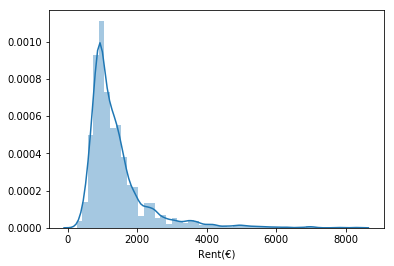

In [4]:
sns.distplot(df["Rent(€)"]);
plt.show()

This Function will show us the number of announcements in an interactive
SVG Image.
This Map and the algorithm which manipulate it were created by Younès Fkih.
We didn't find a map which shows Paris districts so we implemented it. 
This Map is based on LXML and scraping notions. ;))

In [5]:
def showAnnoucementRepartition():
    
    statsAnnoucements = (df.groupby('Zip Code').size())
    statsAnnoucementsDictionnary={}
    #Changing list of tuple to a dictionnary to offer the possibility to get directrly the value by name
    for (ZipCode,nbAnnouncements) in statsAnnoucements.iteritems():
           statsAnnoucementsDictionnary[str(ZipCode)] = nbAnnouncements

    filename ='./paris.svg'
    with open( filename, 'r') as infile: 
        tree = et.parse(infile)
        svg = tree.getroot()
    
    '''
        Modifying tooltip SVG Content Text with the stats
    '''
    for arrEndingRegex in range(1,21):
        zipeCode= str(75000+arrEndingRegex)
        announcementsNumber = 0
        if(zipeCode in statsAnnoucementsDictionnary):
            announcementsNumber=statsAnnoucementsDictionnary[zipeCode]
        idKey = "arrondissementNumber"+str(arrEndingRegex)        
        tree.xpath('//*[@id="'+idKey+'"]')[0].text = str(announcementsNumber)    
    display(SVG(et.tostring(tree, pretty_print=True)))
    display(HTML('<h4><center>ads by district</center></h4>'))

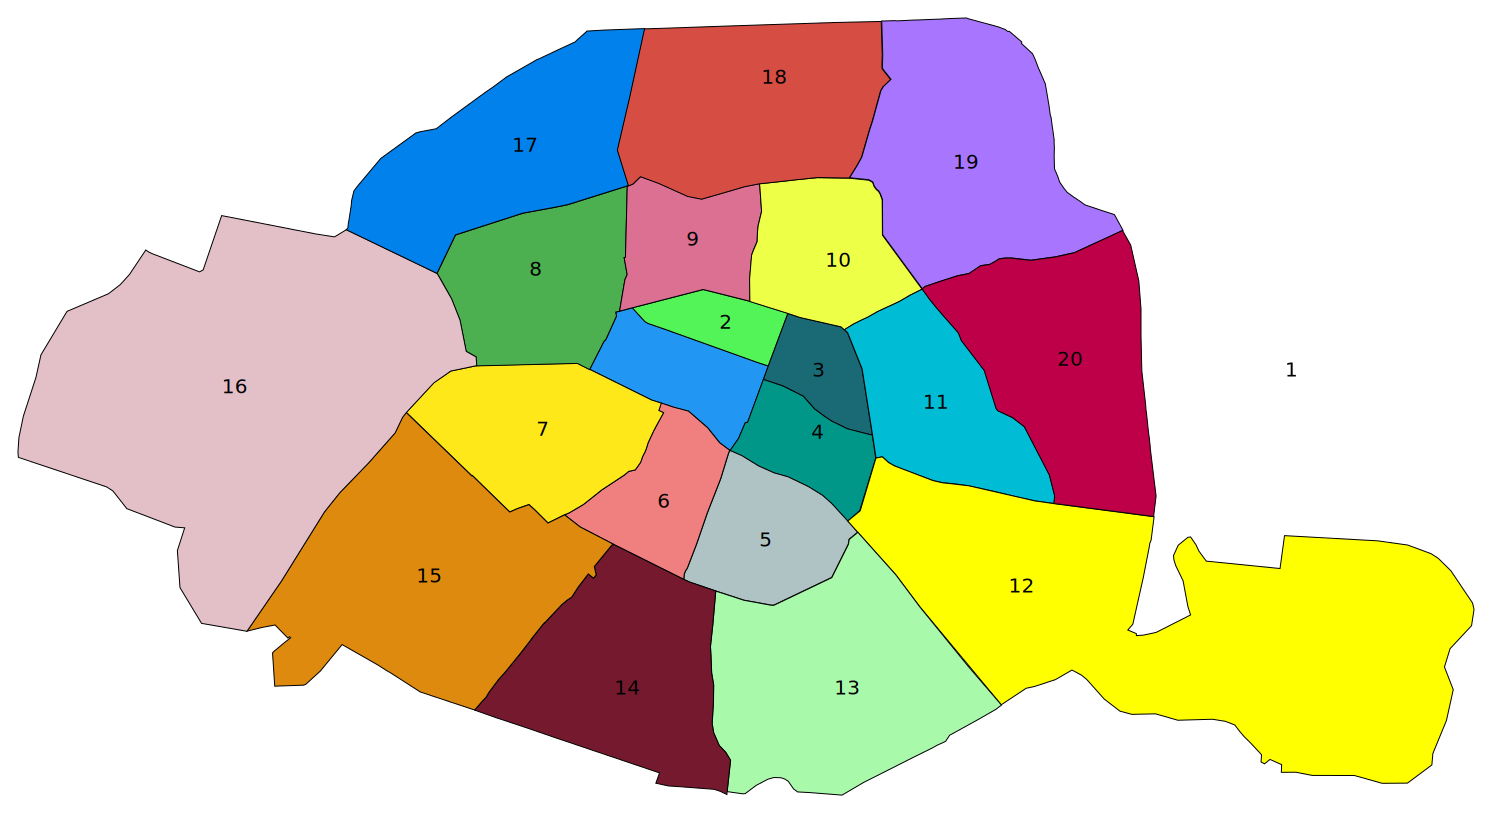

In [6]:
showAnnoucementRepartition()

In [16]:
def generateBarChartForAnnouncements():
    ListArrond = df["Zip Code"].unique()
    StatsPerCategoryDistrict = {} #Dictionnary For stats per Category
    for (ZipCode,nbAnnouncements) in df.groupby(['Zip Code','Rent from Agency']).size().iteritems(): #Filtering on Ads Owner and Zip Codes
            if(not (str(ZipCode[0]) in StatsPerCategoryDistrict )):
                StatsPerCategoryDistrict[str(ZipCode[0])] = {}
                StatsPerCategoryDistrict[str(ZipCode[0])]["Individual"] = nbAnnouncements
            else :
                StatsPerCategoryDistrict[str(ZipCode[0])]["Agency"]=nbAnnouncements

    #Constructing list of tuples for the plot library
    AnnouncementsAgency = ()                         
    AnnouncementsIndividual = ()                         
    for zipCode in sorted(ListArrond) :
        AnnouncementsAgency = AnnouncementsAgency + (StatsPerCategoryDistrict[str(zipCode)]["Agency"],)
        AnnouncementsIndividual = AnnouncementsIndividual + (StatsPerCategoryDistrict[str(zipCode)]["Individual"],)

    ind = np.arange(20)  # the x locations for the groups
    width = 0.35       # the width of the bars
    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(ind, AnnouncementsAgency, width, color='r')
    rects2 = ax.bar(ind + width, AnnouncementsIndividual, width, color='B')
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Number of announcements')
    ax.set_xlabel('District')
    ax.set_title('Rent Announcements by owner and district')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels([str(elt)[-2:] for elt in sorted(ListArrond)])
    ax.legend((rects1[0], rects2[0]), ('Agency', 'Individual'))

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    #Modifying the plot size
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.show()


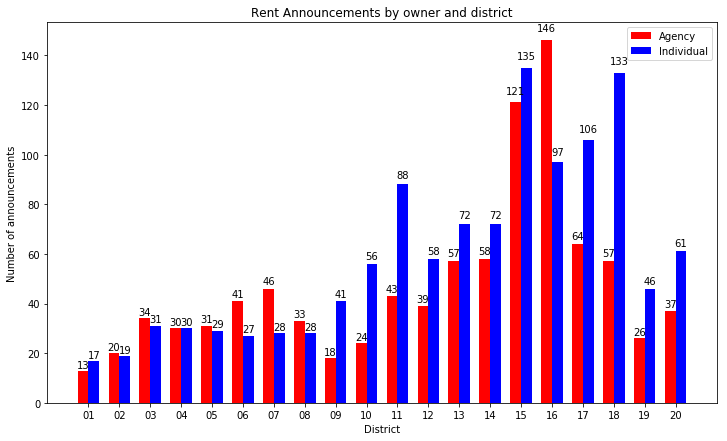

In [17]:
generateBarChartForAnnouncements()
# Agencies have an hyper activity in the 15 and 16th districts.
# In other districts we have a similar activities for Individual and agencies.

This Vizualisation aims to show users which district would be more interesting for them based on their choice.it's maybe more easy to rent an appart in the 18th, 17th or 15th district than another district.

In [205]:
def getNumberOfRoomsByDistrict():
    ListArrond = [str(elt) for elt in sorted(df["Zip Code"].unique())]
    StatsPerCategoryDistrict = {} #Dictionnary For stats per Category
    maxOfRooms = df["Rooms Number"].max() #Getting max OF rooms number in our dataFrame
    minOfRooms = df["Rooms Number"].min() #Getting min OF rooms number in our dataFrame
    #Init the stats
    for elt in ListArrond :
        StatsPerCategoryDistrict[elt] = [0]*(int(maxOfRooms)-int(minOfRooms)+1) #Supposing that we have 0 rooms count for each appart nulber of rooms
    
    #updating Number oF rooms 
    iterableFiltredData = df.groupby(["Zip Code","Rooms Number"]).size().iteritems()
    for ((ZipCode,roomsNumber),count) in iterableFiltredData : 
        StatsPerCategoryDistrict[str(ZipCode)][int(roomsNumber)-1]=count 
    
    #Transforming list to Tuple for the matplotLib
    for key in StatsPerCategoryDistrict:
        StatsPerCategoryDistrict[key]=tuple(StatsPerCategoryDistrict[key]) # Getting tuple from list
    
    #ploting Part
    ArrayNumberOfRooms = tuple([cpt for cpt in range(int(minOfRooms),int(maxOfRooms)+1)]) #Getting Tuple of rooms possible number
    row = 1
    column = 0 
    grid  = (int(len(ListArrond)/3)+2,3)
    fig = plt.subplots(squeeze=False,figsize=(10, 20))
    for key in StatsPerCategoryDistrict:
        #plotting coordinates calculating
        column = column + 1
        if(column % 4 == 0 ):
            row = row + 1
            column = 1
        ax = plt.subplot2grid(grid, (row-1, column-1))# placing the subplot on the grid
        ax.bar(ArrayNumberOfRooms, StatsPerCategoryDistrict[key])
        ax.set_ylabel('nb apparts',fontsize=8)# Y axix label
        ax.set_xlabel('nb rooms',fontsize=8) # X axix label
        ax.set_title(" nb apparts by room's number for "+key,fontsize=8) #settigna  title
        ax.set_xticks(ArrayNumberOfRooms) #Showing all range of number of rooms on the x axis
        ax.set_yticks(StatsPerCategoryDistrict[key], minor=True) #Showing all range of number of rooms on the x axis
        
    plt.tight_layout()
    plt.show()

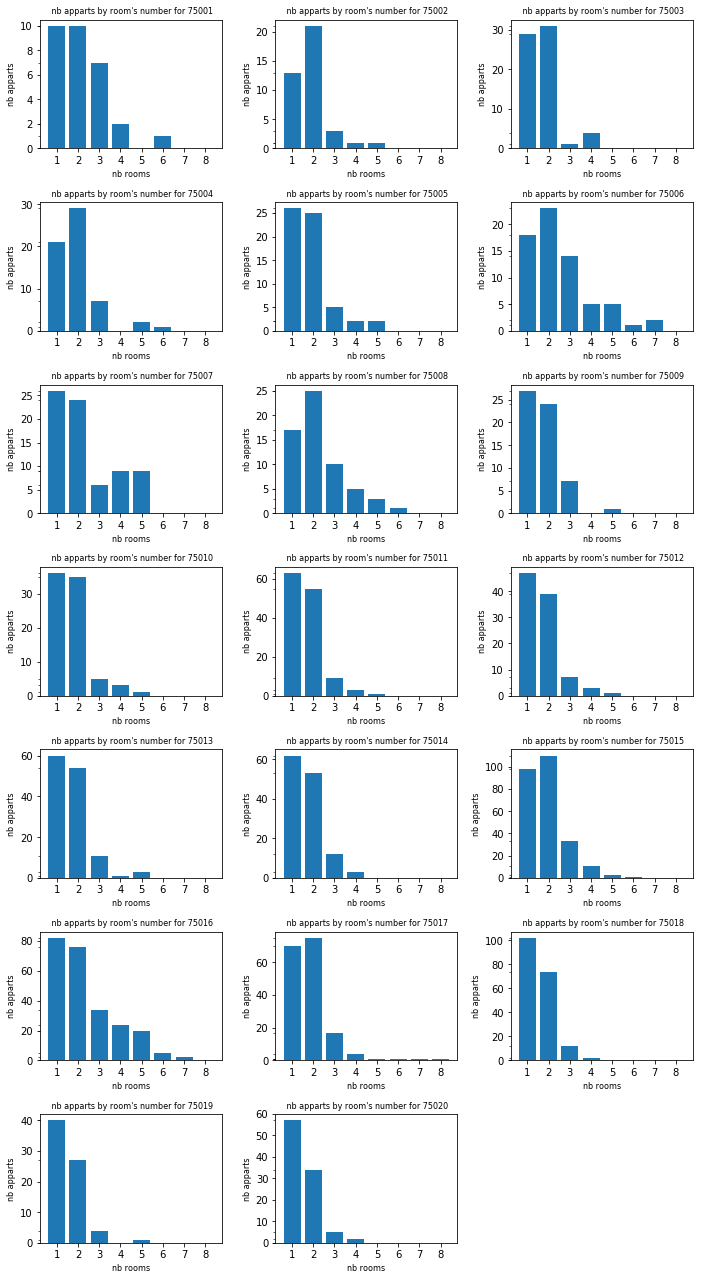

In [206]:
getNumberOfRoomsByDistrict()

This Function aims to show user amounts of meter square rent in the district of paris.
It aims also to show him the difference between an agency and an individual meter sqaure rent's amount.
It will also show him the difference between the real amount and the amout fixed by the frensh government.

In [207]:
def getMeanRentAmoutSquareMeterByDistrict():
    #Getted Amount from http://www.linternaute.com/argent/immobilier/prix-au-m-l-immobilier-dans-600-villes-de-france/paris.shtml
    officalAmounts=[37.31,33.70,36.26,37.69,34.41,36.70,34.86,36.71,30.57,28.34,30.47,28.34,28.48,28.81,29.49,30.43,30.79,28.60,25.09,25.91]
    ListArrond = [str(elt) for elt in sorted(df["Zip Code"].unique())]
    StatsPerCategoryDistrict = {} #Dictionnary For stats per Category
    for elt in ListArrond :
        StatsPerCategoryDistrict[elt] = {"averageIndiv":[],"averageAgency":[]}

    #Regrouping dataFrame columns by zipCode and Area and type of Rent. --> Deducting the unit price of a square meter
    filtredData = df.groupby(["Zip Code","Rent(€)","Area","Rent from Agency"]).size().iteritems()
    for ((ZipCode,rent,area,isAgency),count) in filtredData : #Filtering on Ads Owner and Zip Codes
            if(int(isAgency) == 0):
                StatsPerCategoryDistrict[str(ZipCode)]["averageIndiv"].append(float(rent)/float(area))
            else:
                StatsPerCategoryDistrict[str(ZipCode)]["averageAgency"].append(float(rent)/float(area))

    averageRentMeterIndividual = []
    averageRentMeterAgency = []
    for elem in ListArrond:
        #get avg from list:
        averageIndividual = sum(StatsPerCategoryDistrict[elem]["averageIndiv"]) / float(len(StatsPerCategoryDistrict[elem]["averageIndiv"])) #avg from list of float
        averageAgency = sum(StatsPerCategoryDistrict[elem]["averageAgency"]) / float(len(StatsPerCategoryDistrict[elem]["averageAgency"])) #avg from list of float
        #Constructing list of plots
        averageRentMeterIndividual.append(averageIndividual)
        averageRentMeterAgency.append(averageAgency)
 
    #plotting After preparing data
    grid  = (3,1)
    #first schema
    fig = plt.subplots(squeeze=False,figsize=(10, 5))
    ax = plt.subplot2grid(grid, (0, 0))# placing the subplot on the grid
    line1 = ax.plot(ListArrond,averageRentMeterIndividual, linewidth=1,color="#f08080",
                     label='M² Rent Amount 2017',marker='o',markersize=4)
    line2 = ax.plot(ListArrond,officalAmounts, linewidth=1,color="black",
                     label='M² Rent Amount 2014',marker='o',markersize=4)
    ax.set_xticklabels([str(elt)[-2:] for elt in sorted(ListArrond)],fontsize=6)
    ax.legend(loc="best")
    #line1.set_dashes(dashes)
    #get Data of meter square rent price from somewhere on the net then display it in the same Graph
    ax.set_ylabel('Rent amount',fontsize=7)
    ax.set_xlabel('District',fontsize=7)
    ax.set_title('Meter Square Rent Amout Average for Individual Apparts by district',fontsize=8)
    plt.tight_layout()

    #second schema
    ax = plt.subplot2grid(grid, (1, 0))# placing the subplot on the grid
    line1 = ax.plot(ListArrond,averageRentMeterAgency, linewidth=1,color="#f08080",
                     label='M² Rent Amount 2017',marker='o',markersize=4)
    ax.set_xticklabels([str(elt)[-2:] for elt in sorted(ListArrond)],fontsize=6)
    line2 = ax.plot(ListArrond,officalAmounts, linewidth=1,color="black",
                     label='M² Rent Amount 2014',marker='o',markersize=4)

    ax.legend(loc="best")
    #line1.set_dashes(dashes)
    #get Data of meter square rent price from somewhere on the net then display it in the same Graph
    ax.set_ylabel('Rent amount',fontsize=7)
    ax.set_xlabel('District',fontsize=7)
    ax.set_title('Meter Square Rent Amout Average for Agencies Apparts by district',fontsize=8)
    plt.tight_layout()

    #Third schema
    ax = plt.subplot2grid(grid, (2, 0))# placing the subplot on the grid
    line1 = ax.plot(ListArrond,averageRentMeterAgency, linewidth=1,color="#f08080",
                     label='Agencies M² Rent  Amount 2017',marker='o',markersize=4)
    ax.set_xticklabels([str(elt)[-2:] for elt in sorted(ListArrond)],fontsize=6)
    line2 = ax.plot(ListArrond,averageRentMeterIndividual, linewidth=1,color="black",
                     label='Individuals M² Rent Amount 2017',marker='o',markersize=4)

    #line1.set_dashes(dashes)
    #get Data of meter square rent price from somewhere on the net then display it in the same Graph
    ax.set_ylabel('Rent amount',fontsize=7)
    ax.set_xlabel('District',fontsize=7)
    ax.set_title('Meter Square Rent Amout Average for Agencies Apparts and Individuals by district',fontsize=8)   
    ax.legend(loc="best")

    plt.show() 


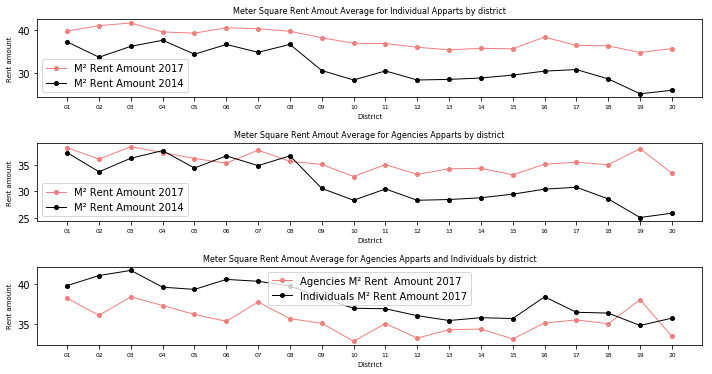

In [208]:
getMeanRentAmoutSquareMeterByDistrict()

In [209]:
def RepartFurnished():
    
    ListArrond = [str(elt) for elt in sorted(df["Zip Code"].unique())]
    StatsPerCategoryDistrict = {} #Dictionnary For stats per Category
    for elt in ListArrond :
            StatsPerCategoryDistrict[elt] ={}
            StatsPerCategoryDistrict[elt]["Indiv"]={"furnished":0,"unfurnished":0}
            StatsPerCategoryDistrict[elt]["Agency"]={"furnished":0,"unfurnished":0}

    
    #Regrouping dataFrame columns by zipCode and Area and type of Rent. --> Deducting the unit price of a square meter
    filtredData = df.groupby(["Zip Code","is furnished","Rent from Agency"]).size().iteritems()
    for ((ZipCode,isfurnished,isAgency),count) in filtredData : #Filtering on Ads Owner and Zip Codes
        if(isAgency == 0):
            if(isfurnished == 0):
                StatsPerCategoryDistrict[str(ZipCode)]["Indiv"]["unfurnished"] = count
            else:
                StatsPerCategoryDistrict[str(ZipCode)]["Indiv"]["furnished"] = count
        else:
            if(isfurnished == 0):
                StatsPerCategoryDistrict[str(ZipCode)]["Agency"]["unfurnished"] = count
            else:
                StatsPerCategoryDistrict[str(ZipCode)]["Agency"]["furnished"] = count

                
    AgencyFunishedRepartiotion = [0,0]
    IndividualFunishedRepartiotion = [0,0]      
    for zipCode in StatsPerCategoryDistrict:            
        AgencyFunishedRepartiotion[0]=AgencyFunishedRepartiotion[0]+StatsPerCategoryDistrict[zipCode]["Agency"]["furnished"]
        AgencyFunishedRepartiotion[1]=AgencyFunishedRepartiotion[1]+StatsPerCategoryDistrict[zipCode]["Agency"]["unfurnished"]
        IndividualFunishedRepartiotion[0]=IndividualFunishedRepartiotion[0]+StatsPerCategoryDistrict[zipCode]["Indiv"]["furnished"]
        IndividualFunishedRepartiotion[1]=IndividualFunishedRepartiotion[1]+StatsPerCategoryDistrict[zipCode]["Indiv"]["unfurnished"]
        
        
        
    allUnfurnishedApparts = 0
    allfurnishedApparts = 0
    filtredData = df.groupby(["is furnished"]).size().iteritems()
    for (isfurnished,count) in filtredData : #Filtering on Ads Owner and Zip Codes
        if(isfurnished):
            allfurnishedApparts = count
        else:
            allUnfurnishedApparts = count
                
    

    #plotting After preparing data
    grid  = (1,3)
    #first schema
    fig = plt.subplots(squeeze=False,figsize=(12, 4))

    labels = ('furnished apparts', 'unfurnished apparts')
    colored=["#42e1f9","#fcb315"]
    explode = (0, 0.08)  # only "explode" the 2nd slice (i.e. 'Hogs')
    
    ax1 = plt.subplot2grid(grid, (0, 0))# placing the subplot on the grid
    ax1.pie([allfurnishedApparts,allUnfurnishedApparts], explode=explode, labels=labels, autopct='%1.1f%%',colors=colored,shadow=True)
    plt.title('Repartition of Apparts', bbox={'facecolor':'0.8', 'pad':5},fontsize=8)
    
    ax1 = plt.subplot2grid(grid, (0, 1))# placing the subplot on the grid
    ax1.pie(IndividualFunishedRepartiotion, explode=explode, labels=labels, autopct='%1.1f%%',colors=colored,shadow=True)
    plt.title('Repartition of Individual Apparts', bbox={'facecolor':'0.8', 'pad':5},fontsize=8)

    ax1 = plt.subplot2grid(grid, (0, 2))# placing the subplot on the grid
    ax1.pie(AgencyFunishedRepartiotion, explode=explode, labels=labels, autopct='%1.1f%%',colors=colored,shadow=True)
    plt.title('Repartition of Agencies Apparts', bbox={'facecolor':'0.8', 'pad':5},fontsize=8)

    plt.show()


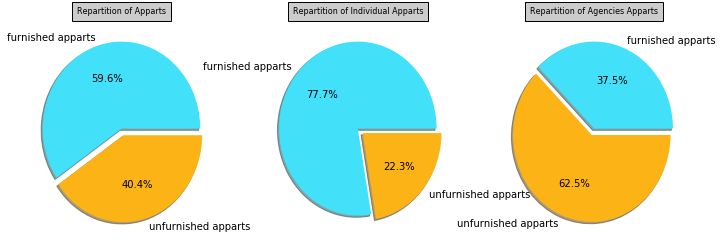

In [210]:
RepartFurnished()  

In [211]:
def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(0, 0%%, %d%%)' % random.randint(50, 100)

def generateWordCloud(dframe):
    limit = 1000
    infosize = 12
    descriptionText = " ".join(dframe['description'].astype(str))
    title = 'Top 1000 frequent words'
    fontcolor='black'
    bgcolor = '#000000'
    stopword = stopwords.words('french')
    wordcloud = WordCloud(
        max_words=1000,
        stopwords=stopword,
        mask=imread('./Holmes_silhouette.png'),
        background_color=bgcolor,
    ).generate(descriptionText)
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(18)
    plt.imshow(wordcloud.recolor(color_func=grey_color, random_state=3))
    plt.title(title, color=fontcolor, size=30, y=1.01)
    plt.axis('off')
    plt.show()

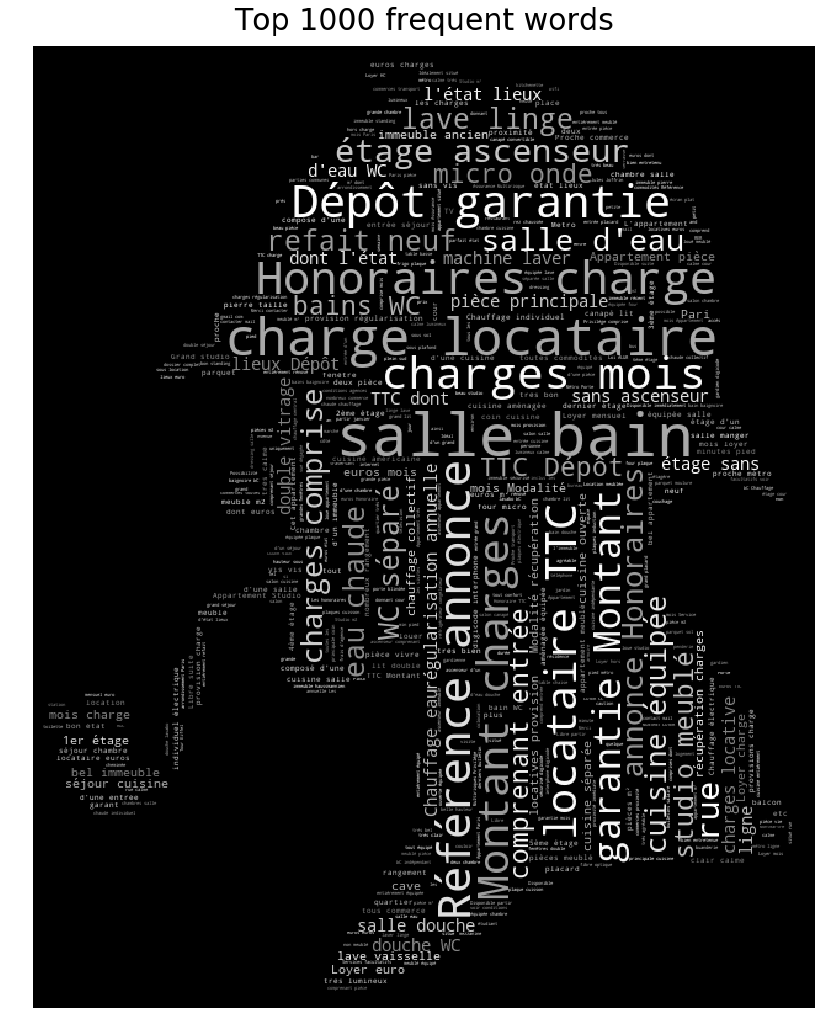

In [212]:
generateWordCloud(df)

#### Why a Linear Model

After scrapping data and preparing it in a data frame we are now able to attack the machine learning models, we'll compare them and choose the most adapted one. In this part we'll devide dataframe into test and traning sets.
Add Data that we'll exploit later

In [213]:
def getRentAmountPerAreaAndDisctrict():
    
    ListArrond = [str(elt) for elt in sorted(df["Zip Code"].unique())]
    StatsPerCategoryDistrict = {} #Dictionnary For stats per Category
    row = 1
    column = 0 
    grid  = (int(len(ListArrond)/3)+2,3)
    fig, ax = plt.subplots(figsize=(12, 7))
    for key in ListArrond:
        #plotting coordinates calculating
        column = column + 1
        if(column % 4 == 0 ):
            row = row + 1
            column = 1
        dfPerDistrict= df[df['Zip Code'] == int(key)]
        sns.regplot(x='Area',y='Rent(€)',data=dfPerDistrict,truncate =True,label=key)
        ax.legend(loc="best")
        plt.title('Varation of the Rent Amount by district', bbox={'facecolor':'0.8', 'pad':5},fontsize=8)

    plt.tight_layout()
    plt.show()
    display(HTML("<div><h6> --> We Observe that the effect of the district is very important on the rent amount</h6></div>"))

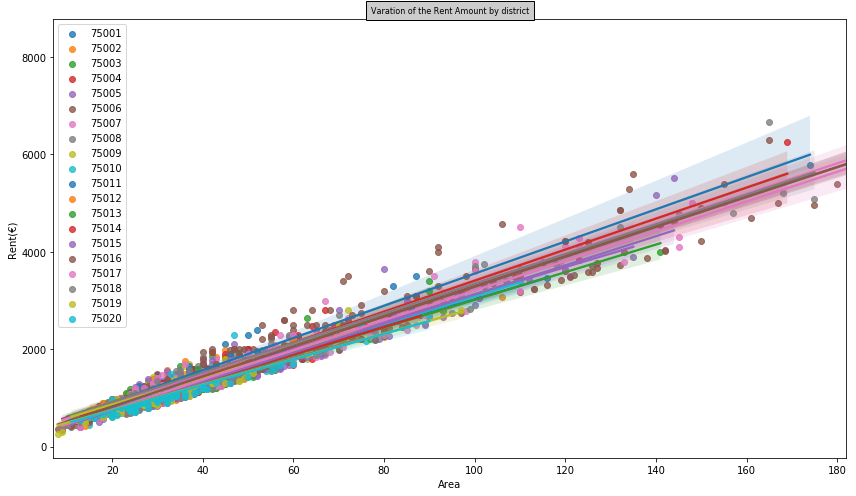

In [214]:
getRentAmountPerAreaAndDisctrict()

#### Filling NaN Values 

In [215]:
df = df.interpolate(method="nearest")

##### Principle Component Analysis (Used For explaining Model and Features interaction)

In [216]:
def myPCA(df, clusters=None):
    # Normalize data
    df_norm = (df - df.mean()) / df.std()
    # PCA
    pca = PCA(n_components=2)
    pca_res = pca.fit_transform(df_norm.values)
    # Ebouli
    ebouli = pd.Series(pca.explained_variance_ratio_)
    plt.show()
    # Circle of correlations
    # http://stackoverflow.com/a/22996786/1565438
    coef = np.transpose(pca.components_)
    cols = ['PC-'+str(x) for x in range(len(ebouli))]
    pc_infos = pd.DataFrame(coef, columns=cols, index=df_norm.columns)
    circleOfCorrelations(pc_infos, ebouli)
    plt.show()
    # Plot PCA
    return pc_infos, ebouli

In [217]:
def circleOfCorrelations(pc_infos, ebouli):
    plt.Circle((0,0),radius=10, color='g', fill=False)
    circle1=plt.Circle((0,0),radius=1, color='g', fill=False)
    fig = plt.gcf()
    fig.gca().add_artist(circle1)
    for idx in range(len(pc_infos["PC-0"])):
        x = pc_infos["PC-0"][idx]
        y = pc_infos["PC-1"][idx]
        plt.plot([0.0,x],[0.0,y],'k-')
        plt.plot(x, y, 'rx')
        plt.annotate(pc_infos.index[idx], xy=(x,y))
    plt.xlabel("PC-0 (%s%%)" % str(ebouli[0])[:4].lstrip("0."))
    plt.ylabel("PC-1 (%s%%)" % str(ebouli[1])[:4].lstrip("0."))
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.title("Circle of Correlations")

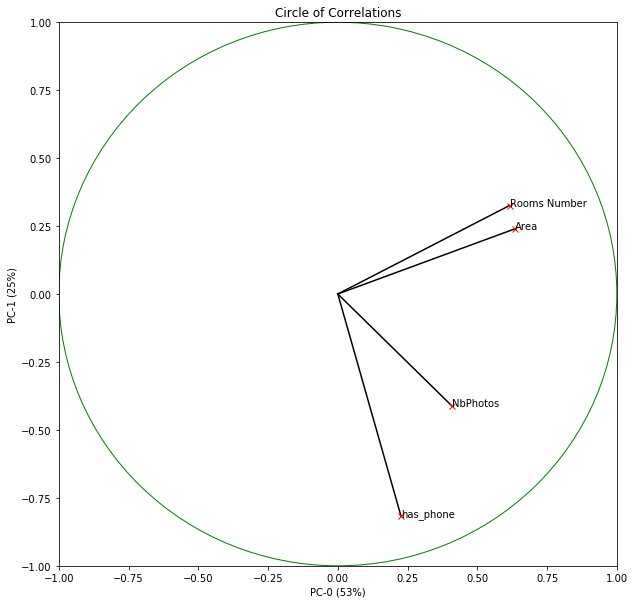

(                  PC-0      PC-1
 Rooms Number  0.615442  0.325604
 NbPhotos      0.408226 -0.411101
 has_phone     0.226371 -0.816958
 Area          0.635090  0.239913, 0    0.530519
 1    0.259347
 dtype: float64)

In [218]:
columns = ['Rooms Number','NbPhotos','has_phone','Area']
dfPca = df[columns]
myPCA(dfPca)

##### Engineered Features

In [219]:
columns = ['Rooms Number','NbPhotos','has_phone','is furnished','Area','Rent from Agency',"F0","F1","F2","F3","F4","F5","F6","F7"]

In [220]:
def stradifyArea(df):

    df['F0'] = df["Area"].apply(lambda x : 1 if(x < 18) else 0 )
    df['F1'] = df["Area"].apply(lambda x : 1 if(x >= 18 and x < 27) else 0 )
    df['F2'] = df["Area"].apply(lambda x : 1 if(x >= 27 and x < 41) else 0 )
    df['F3'] = df["Area"].apply(lambda x : 1 if(x >= 41 and x < 54) else 0 )
    df['F4'] = df["Area"].apply(lambda x : 1 if(x >= 54 and x < 66) else 0 )
    df['F5'] = df["Area"].apply(lambda x : 1 if(x >= 66 and x < 79) else 0 )
    df['F6'] = df["Area"].apply(lambda x : 1 if(x >= 79 and x < 89) else 0 )
    df['F7'] = df["Area"].apply(lambda x : 1 if(x >= 89) else 0 )

    
stradifyArea(df)  

In [221]:
def stradifyZipCode(df,columns):
    for zipCode in range(75001,75021):
        columns.append('in_'+str(zipCode))
        df['in_'+str(zipCode)]= df["Zip Code"].apply(lambda x : 1 if(x == zipCode) else 0 )
stradifyZipCode(df,columns)


In [222]:
#Deleting unused Feature from the model
df = df.drop("description",axis=1)
df = df.drop("Zip Code",axis=1)

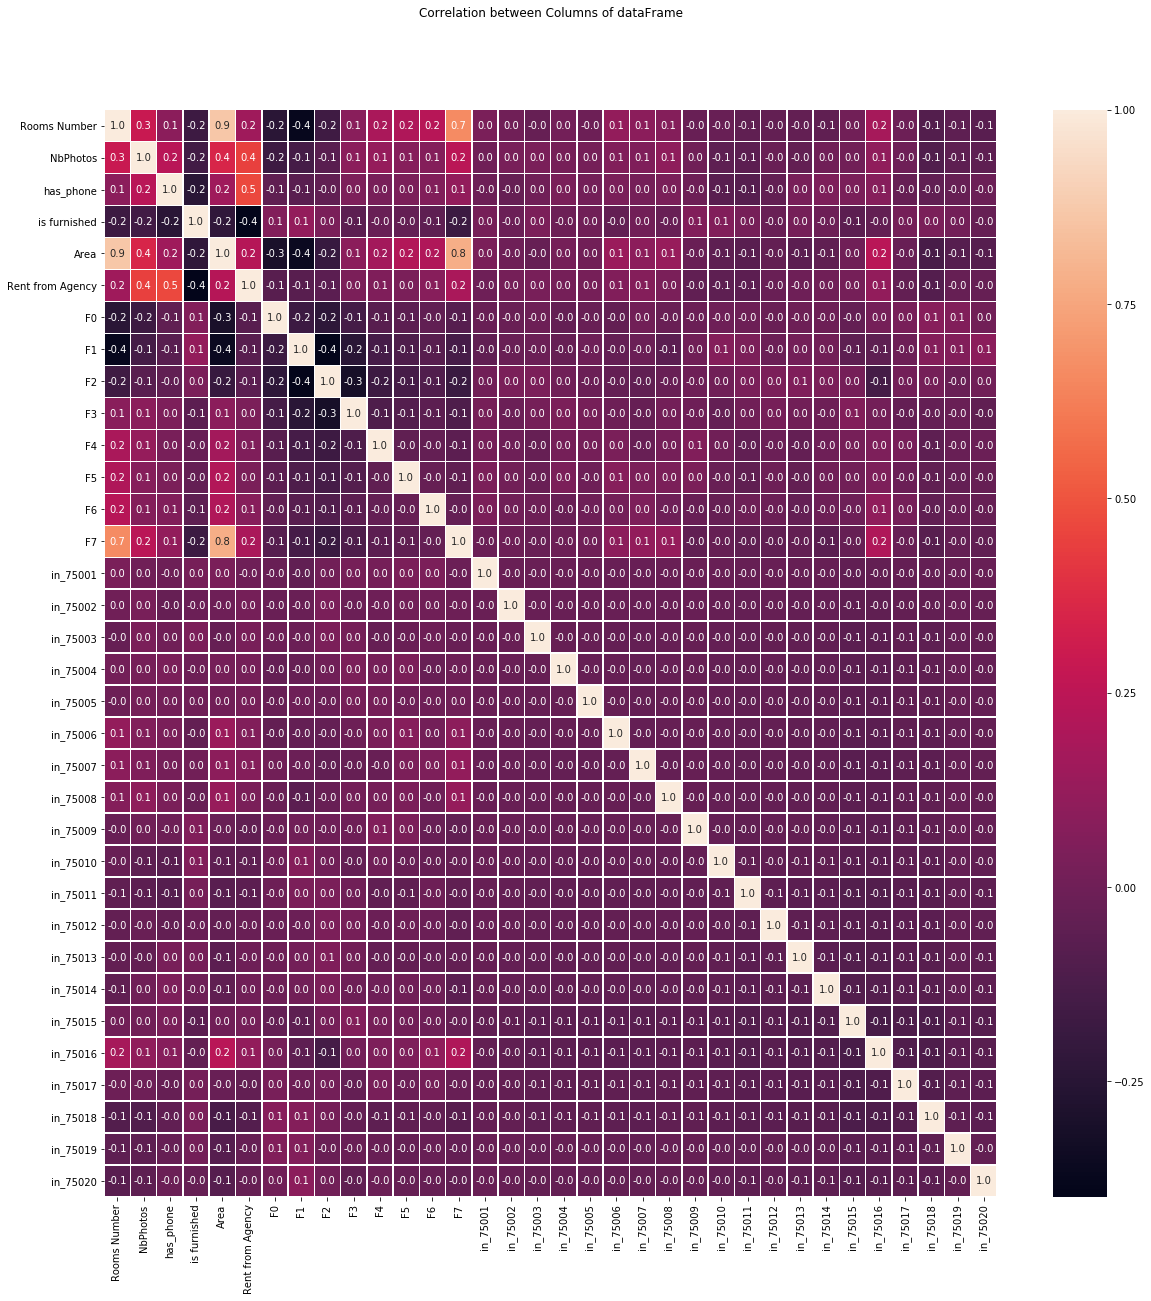

In [223]:
#Getting correlation between df Columns
Correlation = df[columns].corr()
#Plotting other Correlations
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(Correlation, annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title("Correlation between Columns of dataFrame",y=1.08)
plt.show()


#### Machine Learning

In [235]:
# Removing Rooms Number From columns list used for Machine learning
columnsMl = [elt for elt in columns if elt not in ["Rooms Number"]]

In [236]:
#Splitting the dataSet into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[columnsMl],df["Rent(€)"], test_size=0.2, random_state=69,shuffle=True)

In [237]:
def MLTraining(train_X,train_y):
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(train_X, train_y)
    return regr

In [238]:
Model =MLTraining(X_train, y_train)#Getting the Coefficients for the Linear Regression

######  Test

In [239]:
def test(model,test_X,test_y):
    # Make predictions using the testing set
    Rent_pred = model.predict(test_X)
    residuals = test_y - Rent_pred
    print("Residuals Informations")
    print(residuals.describe())

    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(test_y, Rent_pred))
    
    # Plot outputs
    obs = [cpt for cpt in range(1,len(test_y)+1)]
    rentSeriesTest = pd.Series(test_y.tolist())
    obsSeries = pd.Series(obs)
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.regplot(x=obsSeries,y=Rent_pred,truncate =True,color="red",marker="*",label="Predicted Values")
    ax.scatter(obs, rentSeriesTest, color='blue', linewidth=2,label="Real Values")
    ax.set_xticks(obs) #Showing all range of number of rooms on the x axis
    ax.set_yticks(Rent_pred, minor=True) #Showing all range of number of rooms on the x axis
    #line1.set_dashes(dashes)
    ax.set_ylabel('Rent amount',fontsize=7)
    ax.set_xlabel('Test Observation number',fontsize=7)
    ax.set_title('Prediction and real Value in test set',fontsize=8)
    plt.tight_layout()
    ax.legend(loc="best")
    plt.show()
    return Rent_pred

Residuals Informations
count     423.000000
mean        2.677653
std       221.431343
min      -571.453402
25%      -104.517292
50%       -25.086169
75%        68.057662
max      2361.170617
Name: Rent(€), dtype: float64
Variance score: 0.95


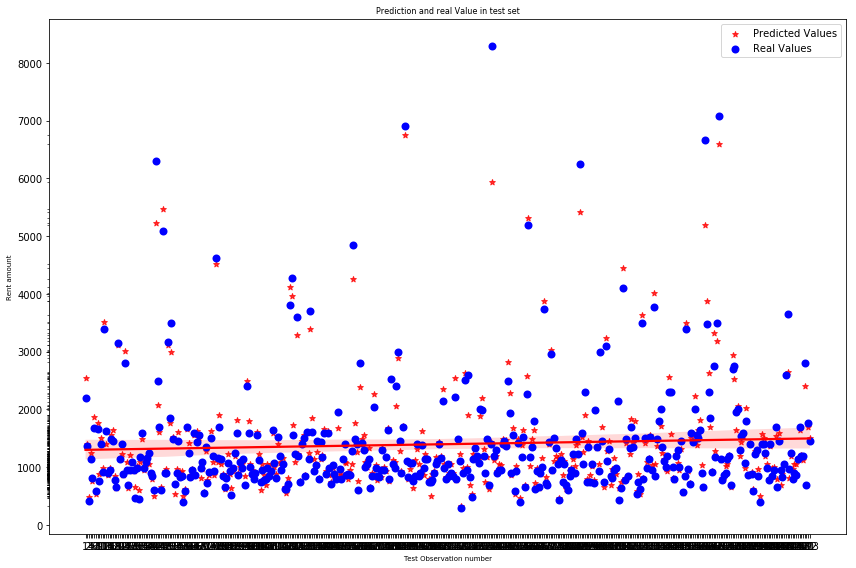

In [240]:
pred = test(Model,X_test, y_test)

This was a POC, we"re still waiting for a positive response from LEBONCOIN. We wanted at the first time to detect Fraudulent
appart's Announcement but we didn't get a data set from the site even when we contacted them.
Now we are waiting for another response maybe we'll treat the problem that we have choosed at first.
Thank You.
Best Regards.